## Prepare data for model

In [4]:
# Use to download data from Kaggle

# import opendatasets as od   # pip install opendatasets

# od.download(
# 	"https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten")  # credentials read automatically from kaggle.json

In [5]:
DATA_PATH = '/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset'

In [6]:
import splitfolders  # pip install split-folders

splitfolders.ratio(DATA_PATH, output="output", seed=1337, ratio=(.8, 0.1,0.1))  # 80-10-10 train-val-test split

Copying files: 29291 files [02:53, 168.63 files/s]


In [7]:
import cv2
import imghdr
import numpy as np
import os

image_exts = ['jpeg','jpg', 'bmp', 'png']  # allowed img formats only

DATA_PATH = '/kaggle/working/output'

for folder in os.listdir(DATA_PATH):
    sub_path = os.path.join(DATA_PATH, folder)
    for dirname,_,filenames in os.walk(sub_path):
        for filename in filenames:
            img_path = os.path.join(sub_path, dirname, filename)
            tip = imghdr.what(img_path)
            if tip not in image_exts:  # remove files from dir if its of incompatible img type
                os.remove(img_path)

## Image preprocessing and split into train/val/test datasets

In [8]:
import tensorflow as tf

# this builds image dataset for us & does preprocessing
    # (reshapes images & batches them up into batch size of 32)

train_data = tf.keras.utils.image_dataset_from_directory('output/train', label_mode='int', image_size=(224, 224), batch_size = 32) 
val_data = tf.keras.utils.image_dataset_from_directory('output/val', label_mode='int', image_size=(224, 224), batch_size = 32) 
test_data = tf.keras.utils.image_dataset_from_directory('output/test', label_mode='int', image_size=(224, 224), batch_size = 32) 

Found 23120 files belonging to 28 classes.
Found 2880 files belonging to 28 classes.
Found 2894 files belonging to 28 classes.


In [9]:
# names of our classifications obtained from train_data

names = train_data.class_names
print(names)

['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten']


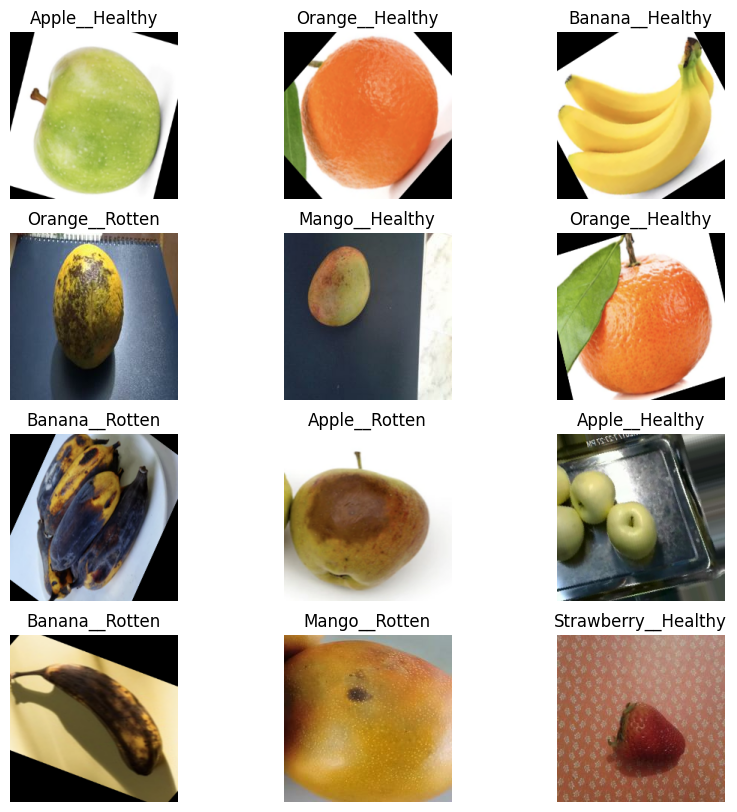

In [10]:
# view images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)    # 4 rows of 3
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(names[int(labels[i])])
        plt.axis("off")

In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_data = train_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

## Build model
- Utilize the pre-trained ResNet50 model and fine tune for our data

In [12]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input

# Create the base model from the pre-trained ResNet50
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling='max')

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.25)(top_model)
output_tensor = Dense(28, activation='softmax')(top_model)

# Define the new model
resnet_model = Model(inputs=base_model.input, outputs=output_tensor)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,651,164 (94.04 MB)

 Trainable params: 1,063,452 (4.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
resnet_model.compile('adam', loss=tf.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [15]:
# callbacks are very useful if you wanted to save your model at specific checkpoint, or to do specific logging

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')   # logs folder

## Training model

In [16]:
epochs=10
history = resnet_model.fit(    # .fit is for training, .predict is for when we make predictions
  train_data,
  validation_data=val_data,
  callbacks=[tensorboard_callback],
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1721678581.221399     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721678581.277930     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


723/723 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 2.1494 - sparse_categorical_accuracy: 0.7184

W0000 00:00:1721678663.221187     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721678668.360476     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


723/723 ━━━━━━━━━━━━━━━━━━━━ 115s 132ms/step - loss: 2.1476 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.2762 - val_sparse_categorical_accuracy: 0.9156
Epoch 2/10
723/723 ━━━━━━━━━━━━━━━━━━━━ 118s 116ms/step - loss: 0.2774 - sparse_categorical_accuracy: 0.9090 - val_loss: 0.2029 - val_sparse_categorical_accuracy: 0.9399
Epoch 3/10
723/723 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9271 - val_loss: 0.1888 - val_sparse_categorical_accuracy: 0.9497
Epoch 4/10
723/723 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - loss: 0.2201 - sparse_categorical_accuracy: 0.9303 - val_loss: 0.1963 - val_sparse_categorical_accuracy: 0.9479
Epoch 5/10
723/723 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - loss: 0.1770 - sparse_categorical_accuracy: 0.9423 - val_loss: 0.1614 - val_sparse_categorical_accuracy: 0.9458
Epoch 6/10
723/723 ━━━━━━━━━━━━━━━━━━━━ 84s 116ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.9464 - val_loss: 0.1737 - val_sparse_categorical_accuracy: 

In [17]:
resnet_model.evaluate(test_data)

91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9631


W0000 00:00:1721679709.891525     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.12855567038059235, 0.9612992405891418]

Sparse Categorical Accuracy of 96.31%

## Analyze Results

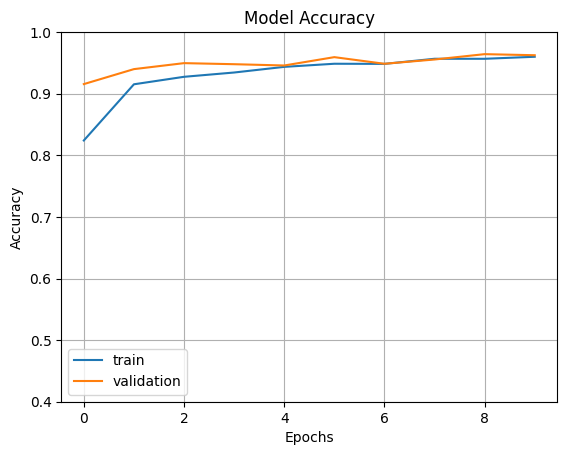

In [18]:
fig1 = plt.gcf()
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

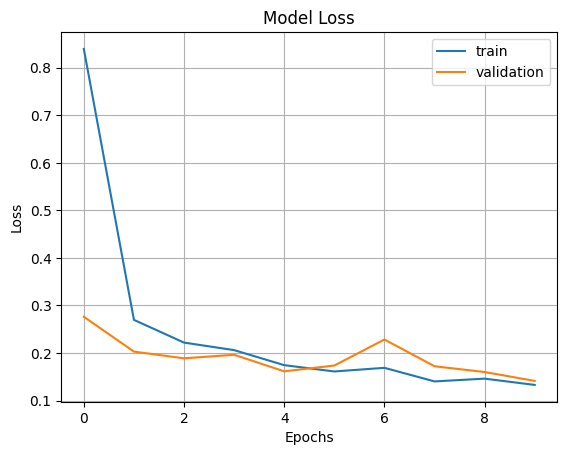

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

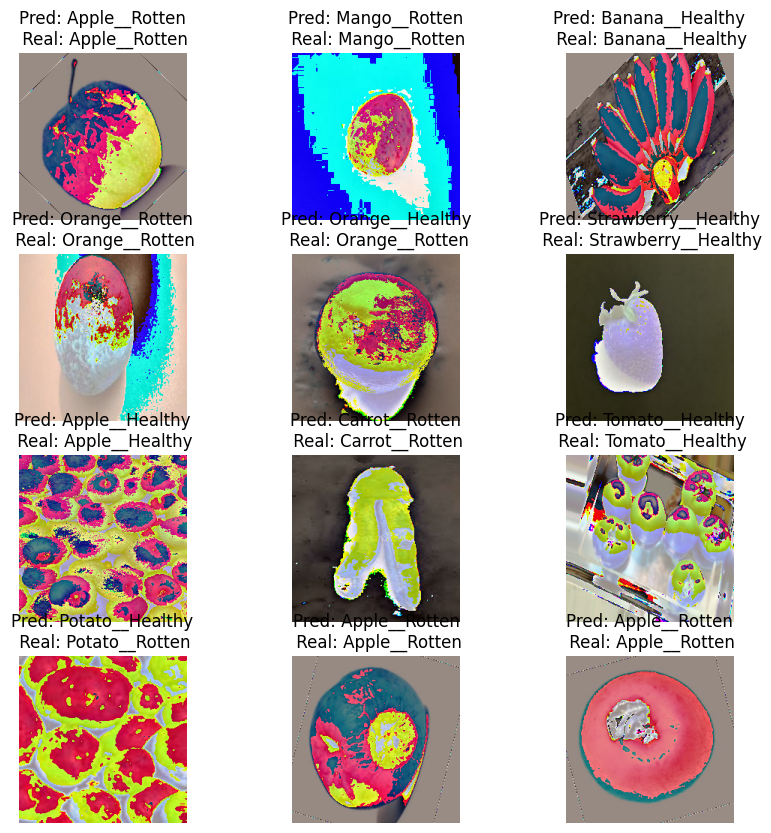

In [20]:
# view test set images predictions vs answer

plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    predictions = resnet_model(images)
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)    # 4 rows of 3
        plt.imshow(np.array(images[i]).astype("uint8"))
        index = np.argmax(predictions[i])
        plt.title("Pred: " + names[index] + "\n Real: " + names[labels[i]])
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


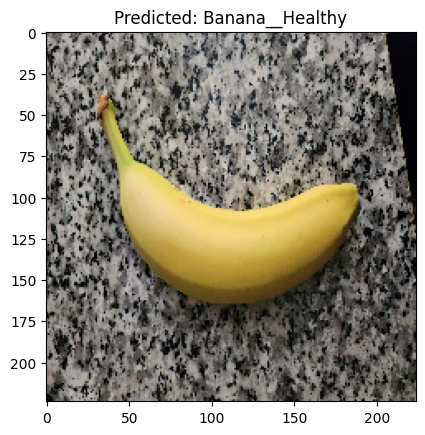

The predicted class is Banana__Healthy


In [21]:
from tensorflow.keras.preprocessing import image

def preprocess_and_predict(img_path, model, labels):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))  
    
    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image
    img_array = preprocess_input(img_array)
    
    # Make the prediction
    preds = model.predict(img_array)
    
    # Get the predicted class
    output_class = labels[np.argmax(preds)]
    
    # Display the image
    plt.imshow(img)
    plt.title(f'Predicted: {output_class}')
    plt.show()

    print(f'The predicted class is {output_class}')

# Example usage
img_path = "/kaggle/input/healthybanana/healthybanana.jpg"

preprocess_and_predict(img_path, resnet_model, names)

## Save Model

In [22]:
# Save Model - so another dev can use it OR it can be deployed as an API

# save inside of models folder
resnet_model.save('produce_health_model.keras')  # .h5 considered legacy

# we can use this file to convert model into a .tflite file for Android development

## Convert Saved Model to TFLite file

In [ ]:
import tensorflow as tf
import keras

# Create a model using high-level tf.keras.* APIs
resnet_model = keras.models.load_model("produce_health_model.keras")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the model.
with open('custommodel.tflite', 'wb') as f:
  f.write(tflite_model)